<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Tackle Imbalanced Data Challenge**


Estimated time needed: **60** minutes


In this lab, you will identify the imbalanced data problems in four binary classification scenarios, all with skewed class distributions:


| Task Name                     | Class Ratio (Negative vs. Positive) |
| ----------------------------- | :---------------------------------: |
| *Credit Card Fraud Detection* |              ~1000 : 1              |
| *Predicting Customer Churn*   |                ~5 : 1               |
| *Tumor Type Estimation*       |                ~2 : 1               |
| *Predicting Job Change*       |               ~10 : 1               |


Next, you will try to tackle the imbalanced data challenges in the above tasks using class weighting and resampling methods:

*   Effective class weighting strategies will assign minority class with more weights, so that it may have a larger impact on the model training process
*   Resampling methods will generate synthetic datasets from the original datasets


## Objectives


After completing this lab you will be able to:


*   Identify typical patterns of imbalanced data challenges
*   Apply `Class Re-weighting` method to adjust the impacts of different classes in model training processes
*   Apply `Oversampling` and `Undersampling` to generate synthetic datasets and rebalance classes
*   Evaluate your consolidated classifiers using robust metrics such as `F-score` and `AUC`


***


First, let us import the required packages for this lab:


In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0

# install imbalanced-learn package
!pip install imbalanced-learn==0.8.0

# Note: If your environment doesn't support "!mamba install", use "!pip install"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 206 kB 5.2 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [2]:
## Import packages here
import pandas as pd
import numpy as np 
import imblearn
from matplotlib.pyplot import figure
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from collections import Counter

First, we want to provide some sample grid search methods if you are interested in tuning your model


In [3]:
rs = 123
# Grid search hyperparameters for a logistic regression model
def grid_search_lr(X_train, y_train):
    params_grid = {
    'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}]
    }
    lr_model = LogisticRegression(random_state=rs, max_iter=1000)
    grid_search = GridSearchCV(estimator = lr_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Grid search hyperparameters for a random forest model
def grid_search_rf(X_train, y_train):
    params_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [25, 50, 100],
    'min_samples_split': [2, 5],
    'class_weight': [{0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}]
    }
    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 5, verbose = 1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

and a method to split training and testing dataset


In [4]:
def split_data(df):
    X = df.loc[ : , df.columns != 'Class']
    y = df['Class'].astype('int')
    return train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

## Scenario: Credit Card Fraud Detection


Let's start with a credit card fraud detection scenario.
The dataset contains transactions made by credit cards. As you can imagine, the majority of transactions are normal and only a very few real fraud transactions are in the dataset. Our goal is to train a classification model to recognize those fraudulent credit card transactions.


First, we load the dataset as a dataframe:


In [7]:
credit_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_credit.csv", index_col=False)

In [8]:
credit_df.head()

,V14,V17,V4,V10,V28,Class
0,0.423619,-0.210863,0.933459,0.027866,0.019308,0
1,0.986727,0.174009,-2.019905,-1.620065,-0.307753,0
2,-0.023094,-0.541985,-0.902618,-0.192212,-0.048965,0
3,-0.152111,-0.615094,1.276126,-0.026822,0.044480,0
4,-0.535807,-0.248563,4.517539,1.871441,0.120955,0


Due to confidentiality issues, the original features and other background information about each transaction is hidden, and this dataset now contains only numerical features which are the result of a PCA transformation.


Next, let's see  how imbalanced this dataset is:


In [9]:
credit_df['Class'].value_counts()

0    200000
1       200
Name: Class, dtype: int64

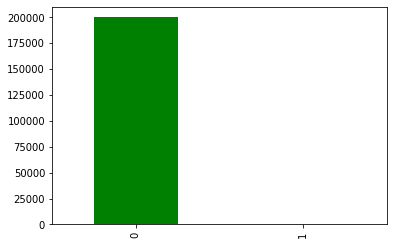

In [10]:
# Visualize the count for each class
credit_df['Class'].value_counts().plot.bar(color=['green', 'red'])

As you can see, we only have about 0.001% fraud transactions in the dataset and you can not even see it on the previous bar chart! This is an extremely imbalanced dataset


Next, we will quickly build a standard logistic regression model to see how it performs on such an imbalanced dataset.


In [11]:
# Split the training and testing dataset
X_train, X_test, y_train, y_test = split_data(credit_df)

In [12]:
# Build a simple logistic regression model
model = LogisticRegression(random_state=rs, 
                              max_iter = 1000)

# Train the model
model.fit(X_train, y_train)
preds = model.predict(X_test)

And check its prediction accuracy


In [13]:
accuracy_score(y_test, preds)

0.9992757242757243

OK, it achieves 99% prediction accuracy on the test dataset, looks like a great model! Before concluding we have found a simple and great model to detect credit card frauds, let's try other metrics first.


### More Robust Evaluation Metrics


Here are some effective robust binary classification evaluation metrics such as Precision, Recall, and Fscore, which can be defined as follows:


*   `Precision`: the percentage of accurately predicted positive instances

*   `Recall`: the percentage of successfully recognized positive instances

*   `Fscore`: can also be called F-beta score, which is a weighted average of precision and recall to evaluate the model. The weights between recall and precision are controlled by the `beta`  parameter, the default value is 1 so the most common F-beta is F1 score


<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/images/evaluation_metrics.png" width="720" alt="evaluation metrics"  />
</center>


In addition, the plot of True positive rate and false positive ratio under different thresholds, known as Receiver operating characteristic `ROC` and its associated Area Under the Curve `AUC` are also reliable metrics.


First let's calculate Precision, Recall, and Fscore.


In [14]:
# Calculate the precision, recall, f5 given the y_test and predictions
# Note that we use beta=5 which means we think the cost of positive class is 5 times of negative class
# You could try other beta values yourself
accuracy = accuracy_score(y_test, preds)
precision, recall, fbeta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {fbeta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 1.00
Precision is: 0.72
Recall is: 0.45
Fscore is: 0.46
AUC is: 0.72


For many machine learning tasks on imbalanced datasets, like this credit card fraud detection, we normally care more about recall than precision. As a baseline, we want the model to be able to find all frauds and we would allow the model to make false-positive errors because the cost of false positives is usually not very high (maybe just costs a false notification email or phone call to confirm with customers). On the other hand, failing to recognize positive examples (such as fraud or a deadly disease) can be life-threatening

As such, our priority is to improve the model's recall, then we will also want to keep precision as high as possible.


### Synthetic Minority Oversampling Technique (SMOTE)


SMOTE first creates many pairs or small clusters with two or more similar instances, the measure by instance distance such as Euclidean distance.
Then, within the boundary of each pair or cluster, SMOTE uniformly permutes features value, one feature at a time, to populate a collection of similar synthesized instances within each pair or cluster.

As a result, SMOTE creates a class-balanced synthetic dataset without adding duplicated instances with minority labels.


The `imblearn` package provides us with many effective samplers including `SMOTE`, `RandomOverSampler`, and `RandomUnderSampler`. Let's use its `SMOTE` class to define a SMOTE sampler first


In [15]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [16]:
# Create a SMOTE sampler
smote_sampler = SMOTE(random_state = rs)

In [17]:
# Resample training data using SMOTE
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

After SMOTE resampling, we can see both positive and negative class has the same instances


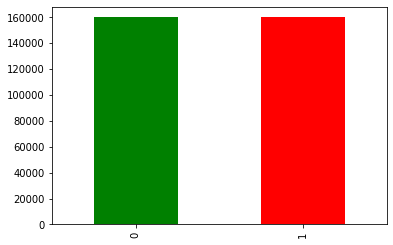

In [18]:
# Visualize classes
y_smo.value_counts().plot.bar(color=['green', 'red'])

Let's retrain the logistic regression model with resampled training data using SMOTE


In [19]:
# Re-train the model with resampled data
model.fit(X_smo, y_smo)
preds = model.predict(X_test)

and re-evaluate the model to see if there are any improvements with respect to Precision, Recall, and F1


In [20]:
# Calculate the precision, recall, f5 given the y_test and predictions
# Note that we use beta=5 which means we think the cost of positive class is 5 times of negative class
# You could try other beta values yourself
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 0.97
Precision is: 0.03
Recall is: 0.88
Fscore is: 0.42
AUC is: 0.92


First, we can see AUC is improved from 0.72 to 0.91, this is a good sign as SMOTE improves model classification ability.


Next, let's take a look at the recall. The recall is now 0.88, mostly two times larger than the original recall value of 0.45.


However, our model's precision is only 0.03. One possible reason is our dataset was extremely skewed, and oversampling the minority class significantly disrupts the original data distribution so that the model trained on the SMOTE dataset generates large false positives on the test dataset sampled from the original dataset.


As such, for an extremely skewed dataset, we generally do not use oversampling as it significantly shifts the original data distribution.


Next, let's try class re-weighting to see if it can achieve better results than SMOTE in terms of Precision, Recall, and Fscore.


### Class reweighting


For binary classification models, its loss function is normally calculated via a sum of the loss with respect to class 0 and the loss with respect to class 1. By default, their class weights are all 1s meaning we treat each class equally important.

However, since the class distribution is skewed in imbalanced datasets and the loss function optimization process will be dominated by the majority class, we want to help the minority class by increasing its class weight in the loss function.


Class weights can be generally calculated via the following three strategies:


*   Based on their instances portion in the dataset. For example, if positive instances only take 10% of the dataset, we assign its weight to be 0.9 and weight for the majority class to be 0.1
*   Heuristics or domain knowledge. Misclassification normally has different costs per class, for example, the cost of failure to diagnose a disease is much higher than a false positive diagnose. If we already know such misclassification costs beforehand, we may use them to assign class weights
*   Hyper-parameter tuning. Standard hyper-parameter tuning methods can be used to find optimized class weights. For example, grid searching from 0.1 to 0.9 for positive class weight to find out which hyperparameter combination generates the best model.


Python `sklearn` package provides a very convenient way to adjust class weights during model training via providing a class weight argument. Many standard classifiers in `sklearn` such as `LogisticRegression` and `RandomForestClassifier` support class reweighting natively.


Let see an example of class reweighting in `LogisticRegression`:


First we just need to create a class weights dict object, and since


In [21]:
class_weight = {}

# Assign weight of class 0 to be 0.1
class_weight[0] = 0.1

# Assign weight of class 1 to be 0.9
class_weight[1] = 0.9

Note that `0.1 vs. 0.9` is a pre-tuned weight combination, you could check the provided `grid_search_lr()` method at the beginning of this lab and use it to tune the optimized class weights yourself.


Next, let's use the class weight dict in a `LogisticRegression` model by specifying its `class_weight` argument.


In [22]:
# Define a logistic regression with weight
model = LogisticRegression(random_state=rs, 
                              max_iter = 1000,
                              class_weight=class_weight)

During the training process, the positive instance will have much larger influence on reducing the total loss and weight updates. The trained classifier will be enhanced to recognize positive instances (increase recall).


In [23]:
# Train the model
model.fit(X_train, y_train)
# Make predictions on the test dataset
preds = model.predict(X_test)

Next, let's see if our metrics are getting better.


In [24]:
# Calculate the precision, recall, f5 given the y_test and predictions
# Note that we use beta=5 which means we think the cost of positive class is 5 times of negative class
# You could try other beta values yourself
precision, recall, f_beta, support = precision_recall_fscore_support(y_test, preds, beta=5, pos_label=1, average='binary')
auc = roc_auc_score(y_test, preds)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy is: {accuracy:.2f}")
print(f"Precision is: {precision:.2f}")
print(f"Recall is: {recall:.2f}")
print(f"Fscore is: {f_beta:.2f}")
print(f"AUC is: {auc:.2f}")

Accuracy is: 1.00
Precision is: 0.65
Recall is: 0.82
Fscore is: 0.82
AUC is: 0.91


As you can see, we have much balanced `Precision` and `Recall` values. It indicates that, for an extremely imbalanced dataset like credit card fraud detection, often class reweighting is a better strategy than oversampling. Since undersampling will significantly shrink the training dataset, we normally do not use undersampling for an extremely imbalanced dataset.


To summarize the findings from the credit card fraud detection task:

*   All models have very high accuracy and AUC values but this does not always mean they have good prediction performance, especially for classifying the fraud cases
*   Classification on an extremly imbalanced dataset is usually a hard task, especially if we want to have both high recall and precision values
*   `SMOTE` can achieve high recall but extremely low precision due to the caused disruptions of original data distribution
*   Class reweighting can achieve a more balanced recall and precision value


Next, let's consolidate your understandings about the imbalanced data challenge with a few more imbalanced classification scenarios.


## Some utility model training and evaluation methods


Before we continue with more imbalanced classification scenarios, let's define some utility methods for you to simplify this lab and increase notebook readability. A method to define and train a logistic regression:


In [25]:
rs = 123
# Build a logistic regression model
def build_lr(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = LogisticRegression(random_state=rs, 
                              max_iter = 1000)
    # If best parameters are provided
    if best_params:
        model = LogisticRegression(penalty = 'l2',
                              random_state=rs, 
                              max_iter = 1000,
                              class_weight=best_params['class_weight'])
    # Train the model
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

A method to define and train a random forest:


In [26]:
def build_rf(X_train, y_train, X_test, threshold=0.5, best_params=None):
    
    model = RandomForestClassifier(random_state = rs)
    # If best parameters are provided
    if best_params:
        model = RandomForestClassifier(random_state = rs,
                                   # If bootstrap sampling is used
                                   bootstrap = best_params['bootstrap'],
                                   # Max depth of each tree
                                   max_depth = best_params['max_depth'],
                                   # Class weight parameters
                                   class_weight=best_params['class_weight'],
                                   # Number of trees
                                   n_estimators=best_params['n_estimators'],
                                   # Minimal samples to split
                                   min_samples_split=best_params['min_samples_split'])
    # Train the model   
    model.fit(X_train, y_train)
    # If predicted probability is largr than threshold (default value is 0.5), generate a positive label
    predicted_proba = model.predict_proba(X_test)
    yp = (predicted_proba [:,1] >= threshold).astype('int')
    return yp, model

A method to evaluate a classifier's predictions


In [27]:
rs = 123
def evaluate(yt, yp, eval_type="Original"):
    results_pos = {}
    results_pos['type'] = eval_type
    # Accuracy
    results_pos['accuracy'] = accuracy_score(yt, yp)
    # Precision, recall, Fscore
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, beta=5, pos_label=1, average='binary')
    results_pos['recall'] = recall
    # AUC
    results_pos['auc'] = roc_auc_score(yt, yp)
    # Precision
    results_pos['precision'] = precision
    # Fscore
    results_pos['fscore'] = f_beta
    return results_pos

A method to resample the original dataset


In [28]:
def resample(X_train, y_train):
    # SMOTE sampler (Oversampling)
    smote_sampler = SMOTE(random_state = 123)
    # Undersampling
    under_sampler = RandomUnderSampler(random_state=123)
    # Resampled datasets
    X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
    X_under, y_under = under_sampler.fit_resample(X_train, y_train)
    return X_smo, y_smo, X_under, y_under

And a method to visualize metrics


In [29]:
def visualize_eval_metrics(results):
    df = pd.DataFrame(data=results)
    #table = pd.pivot_table(df, values='type', index=['accuracy', 'precision', 'recall', 'f1', 'auc'],
    #                columns=['type'])
    #df = df.set_index('type').transpose()
    print(df)
    x = np.arange(5)
    original = df.iloc[0, 1:].values
    class_weight = df.iloc[1, 1:].values
    smote = df.iloc[2, 1:].values
    under = df.iloc[3, 1:].values
    width = 0.2
    figure(figsize=(12, 10), dpi=80)
    plt.bar(x-0.2, original, width, color='#95a5a6')
    plt.bar(x, class_weight, width, color='#d35400')
    plt.bar(x+0.2, smote, width, color='#2980b9')
    plt.bar(x+0.4, under, width, color='#3498db')
    plt.xticks(x, ['Accuracy', 'Recall', 'AUC', 'Precision', 'Fscore'])
    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Score")
    plt.legend(["Original", "Class Weight", "SMOTE", "Undersampling"])
    plt.show()

## Scenario: Predicting Customer Churn


In the second scenario, we will be predicting customer churns (leaving the business) of a telecom company.


First, let's read the dataset


In [30]:
churn_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_churn.csv", index_col=False)

In [31]:
churn_df.head()

,tenure,MonthlyCharges,TotalCharges,Partner_0,Partner_1,Dependents_0,Dependents_1,PhoneService_0,PhoneService_1,MultipleLines_0,...,Contract_0,Contract_1,Contract_2,PaperlessBilling_0,PaperlessBilling_1,PaymentMethod_0,PaymentMethod_1,PaymentMethod_2,PaymentMethod_3,Class
0,27,70.55,1943.90,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
1,69,93.30,6398.05,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,55,59.20,3175.85,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3,49,59.60,2970.30,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,72,109.55,7887.25,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


This dataset is processed and contains features about a customer's telcom service types, tenure, charges, and payments. Based on such features, we would like to predict if a customer is leaving the business or not (churn).


Then, we need to split the data into training and testing datasets,


In [32]:
X_train, X_test, y_train, y_test = split_data(churn_df)

and take a look at its class distribution.


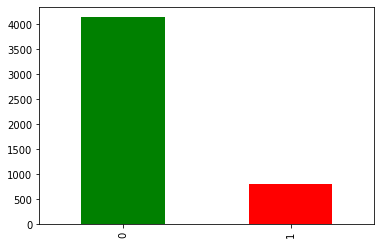

In [33]:
y_train.value_counts().plot.bar(color=['green', 'red'])

As we can see from the bar chart above, the non-churn customers are almost 4 times more than the churn customers, which makes it an imbalanced dataset as well. Since this dataset has 42 features, it would be better to use a more complex classification model and we choose to use `RandomForestClassifier` from `sklearn` package.


`RandomForestClassifier` has many hyperparameters that need to be tuned, we have pre-tuned the main parameters for you. You may also use the provided `grid_search_rf()` method to play with hyperparameter tuning yourself.


In [34]:
# Tuned random forest parameters
best_params_no_weight = {'bootstrap': True,
                         'class_weight': None, 
                         'max_depth': 10, 
                         'min_samples_split': 5, 
                         'n_estimators': 50}

Next, since we want to compare the performance of different models, we create a list to contain all model performance metrics.


In [45]:
results = []

### Train a regular random forest classifier


Then, we will train a regular random forest classifier without any add-ons (class weights or resampling).


In [46]:
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds, "Original")
print(result)
results.append(result)

{'type': 'Original', 'accuracy': 0.8623481781376519, 'recall': 0.28, 'auc': 0.6274396135265701, 'precision': 0.6829268292682927, 'fscore': 0.2865013774104683}


As you may expect, we have a very high prediction `accuracy` but even using a random forest classifier, our `recall` is very low with only 0.28.
Next, let's try the class reweighting method to see if we can improve the performance.


### Add class re-weighting


We will add class weights to the random forest classifier with pre-tuned weight 0.8 to churn class and weight 0.2 to non-churn class.


In [47]:
class_weight = {}
# 0.2 to Non-churn class
class_weight[0] = 0.2
# 0.8 to Churn class
class_weight[1] = 0.8

In [48]:
# Pre-tuned hyper parameters
best_params_weight = {'bootstrap': True,
                         'class_weight': class_weight, 
                         'max_depth': 10, 
                         'min_samples_split': 5, 
                         'n_estimators': 50}

Build a random forest model with the class weight 0.8 vs. 0.2.


In [49]:
# class weight
preds_cw, weight_model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)

Then evaluate the refined model.


In [50]:
result = evaluate(y_test, preds_cw, "Class Weight")
print(result)
results.append(result)

{'type': 'Class Weight', 'accuracy': 0.8137651821862348, 'recall': 0.62, 'auc': 0.7356038647342995, 'precision': 0.4460431654676259, 'fscore': 0.6108374384236454}


As we can see from the evaluation results above, `Recall` and `Fscore` are significantly improved by adding class weights. Such improvements indicate that class reweighting is effective for the imbalanced customer churn dataset.


### Resampling: SMOTE and Undersampling


Then, we want to use resampling to see if it is also able to improve the model performance.


First, we create resampled training datasets:


In [51]:
# X_smo is resampled from X_train using SMOTE
# y_smo is resampled from y_train using SMOTE
# X_under is resampled from X_train using Undersampling
# y_under is resampled from y_train using Undersampling
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

Then we can retrain a random forest classifier using SMOTE resampled input `X_smo` and output `y_smo` and evaluate its performance,


In [52]:
preds_smo, smo_model = build_rf(X_smo, y_smo, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds_smo, "SMOTE")
print(result)
results.append(result)

{'type': 'SMOTE', 'accuracy': 0.8356275303643724, 'recall': 0.505, 'auc': 0.7022584541062802, 'precision': 0.4926829268292683, 'fscore': 0.5045148895292987}


and we can retrain a random forest classifier using the undersampled input `X_under` and output `y_under` and evaluate its performance.


In [53]:
preds_under, under_model = build_rf(X_under, y_under, X_test, best_params=best_params_no_weight)
result = evaluate(y_test, preds_under, "Undersampling")
print(result)
results.append(result)

{'type': 'Undersampling', 'accuracy': 0.7336032388663968, 'recall': 0.79, 'auc': 0.7563526570048309, 'precision': 0.3550561797752809, 'fscore': 0.7544536271809001}


### Compare the performance among different random forest models


By now, we have built four different random forest models: the model trained with the original dataset, the model with class weights, the model trained with SMOTE dataset, and the model trained with undersampling.

To better analyze and compare their performance, we can visualize the metrics using a grouped bar chart.


            type  accuracy  recall       auc  precision    fscore
0       Original  0.862348   0.280  0.627440   0.682927  0.286501
1   Class Weight  0.813765   0.620  0.735604   0.446043  0.610837
2          SMOTE  0.835628   0.505  0.702258   0.492683  0.504515
3  Undersampling  0.733603   0.790  0.756353   0.355056  0.754454


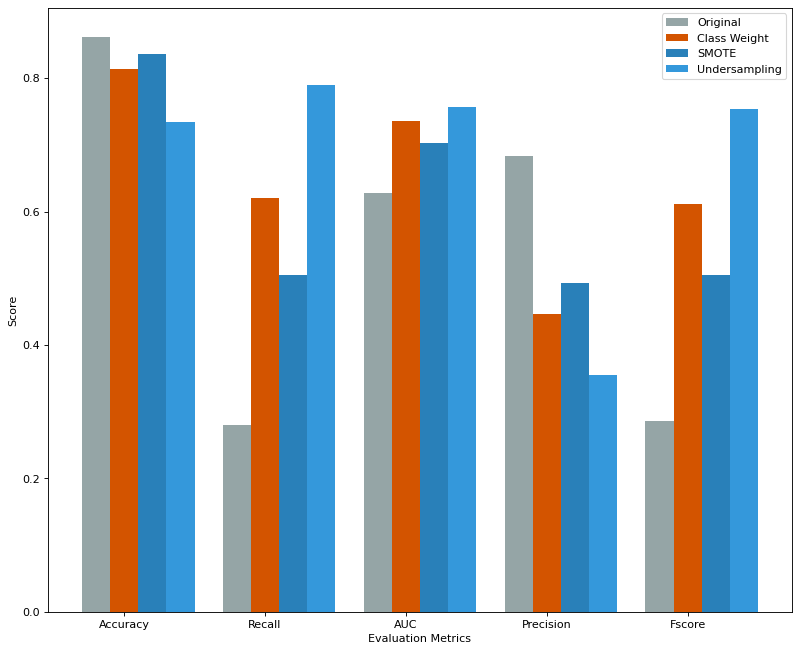

In [54]:
visualize_eval_metrics(results)

Let's first see what each color means. The grey bars represent the original model, the orange bars represent the model with class weight, the dark blue bars represent model trained with SMOTE, and the light blue bars represent the model trained with undersampling.

As we can infer the following insights from the bar charts:


*   All models have high accuracy
*   Recall is improved with class weights and resampling methods, and undersampling produces the highest recall
*   AUC is also improved with class weights and resampling methods, and undersampling produces the highest AUC again
*   Precisions are decreased with class weights and resampling methods as they all introduced many false positives (which are expected as we are trying to increase the impact of the positive class)
*   Fscore is improved with class weights and resampling method, and undersampling has the highest Fscore


By analyzing the bar chart above, we can see that undersampling seems to be the best method to help alleviate the imbalanced challenge in the customer churn dataset. Although all class weights, SMOTE, and undersampling decreased the precision (increased false positives) but sometimes it is not a bad idea to assume some of your customers are about to leave (even if they are not) as motivation to improve your services.


## Scenario: Tumor Type Estimation


Finally, let's see an interesting imbalanced dataset that has very high Precision, Recall, and F-score initially without using class reweighting and resampling.


This dataset contains tumor samples and we need to estimate/predict if a tumor sample is cancerous or not.

First, like other scenarios, let's load and split the dataset


In [55]:
tumor_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_cancer.csv", index_col=False)
X_train, X_test, y_train, y_test = split_data(tumor_df)

and check its class distribution:


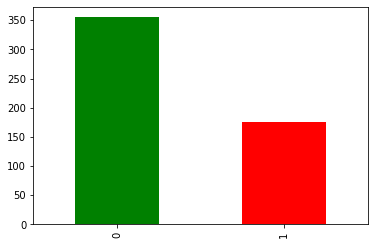

In [56]:
y_train.value_counts().plot.bar(color=['green', 'red'])

As we can see, this dataset is not as imbalanced as previous datasets. So that it is possible we dont need to use class reweighting and resampling in order to have good classification performance.


But we still create synthetic datasets with SMOTE and undersampling and class weights to compare their performance.


In [57]:
X_smo, y_smo, X_under, y_under = resample(X_train, y_train)

Use tuned random forest parameters.


In [58]:
best_params_weight = {'bootstrap': True,
                         'class_weight': {0: 0.2, 1: 0.8}, 
                         'max_depth': 10, 
                         'min_samples_split': 5, 
                         'n_estimators': 50}

Train and evaluate different random forest models on the tumor type dataset.


In [59]:
# no class-weights
results=[]
preds, model = build_rf(X_train, y_train, X_test)
results.append(evaluate(y_test, preds))
# class weight
preds, model = build_rf(X_train, y_train, X_test, best_params=best_params_weight)
results.append(evaluate(y_test, preds))
# Resampling
preds, model = build_rf(X_smo, y_smo, X_test)
results.append(evaluate(y_test, preds))
preds, model = build_rf(X_under, y_under, X_test)
results.append(evaluate(y_test, preds))

       type  accuracy  recall       auc  precision    fscore
0  Original  0.984962     1.0  0.988764   0.956522  0.998255
1  Original  0.992481     1.0  0.994382   0.977778  0.999127
2  Original  0.992481     1.0  0.994382   0.977778  0.999127
3  Original  0.984962     1.0  0.988764   0.956522  0.998255


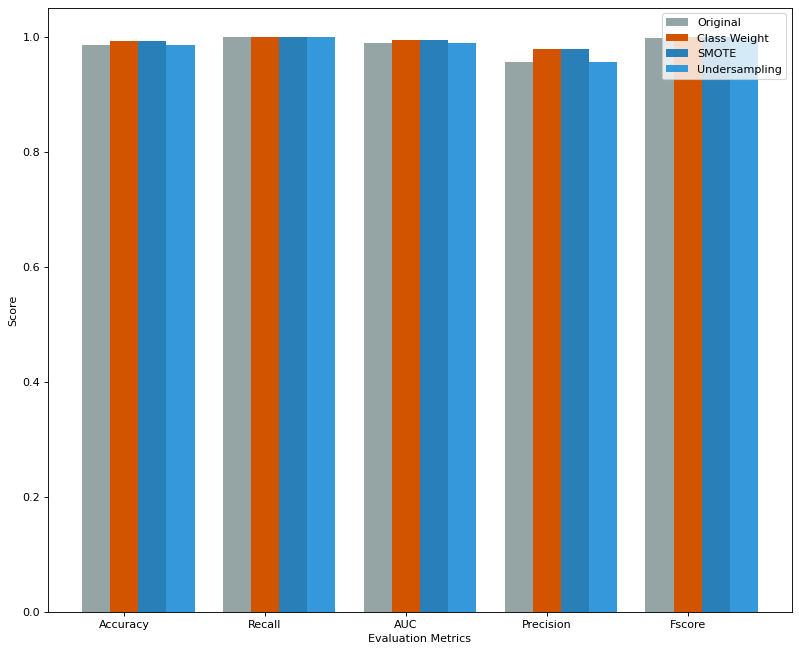

In [60]:
visualize_eval_metrics(results)

As we can see, all grey bars (the original model) for Accuracy, Recall, AUC, Precision, and F-score have very high values and adding class reweighting and resampling does not help improve performance that much. This is possible that the tumor patterns in this dataset are obvious and can be easily picked up by the standard random forest model or the dataset is not very imbalanced and can be considered as an ordinary binary classification task.


## Exercise: Predicting Job Change


Now it is time to apply what you have learned in this lab. We have an imbalanced HR dataset and we want to use it to build a classification model to predict if an employee is looking for a new job or not.


In [61]:
# Load the dataset
hr_df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML201EN-SkillsNetwork/labs/module_4/datasets/im_hr.csv", index_col=False)

### Type your code here


            type  accuracy    recall       auc  precision    fscore
0       Original  0.984962  0.977273  0.983018   0.977273  0.977273
1   Class Weight  0.984962  0.977273  0.983018   0.977273  0.977273
2          SMOTE  0.984962  0.977273  0.983018   0.977273  0.977273
3  Undersampling  0.969925  0.977273  0.971782   0.934783  0.975567


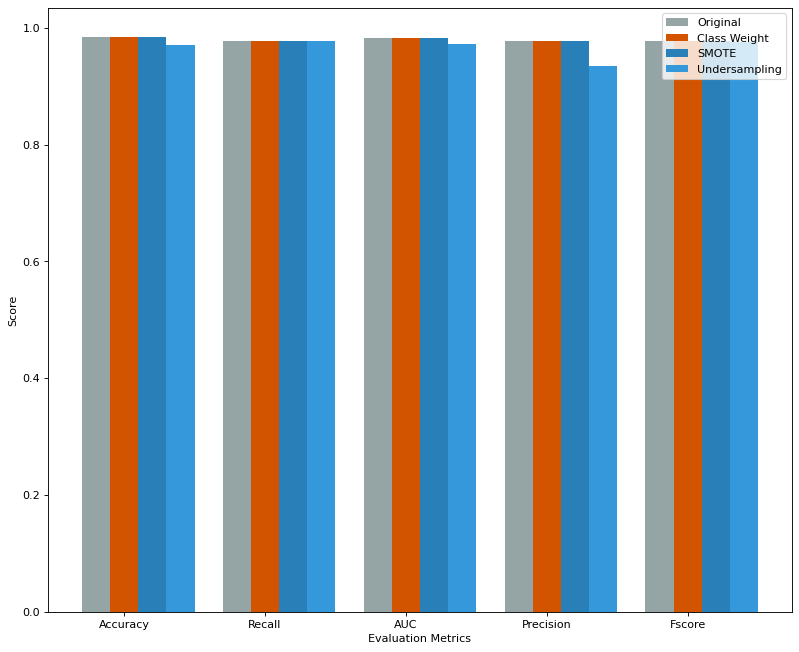

In [62]:
# y_train.value_counts().plot.bar(color=['green', 'red'])
best_params = {'class_weight': {0: 0.1, 1: 0.9}}
results = []
# no class-weights
preds, model = build_lr(X_train, y_train, X_test)
result = evaluate(y_test, preds)
results.append(result)
# class weight
preds, weight_model = build_lr(X_train, y_train, X_test, best_params=best_params)
result = evaluate(y_test, preds, eval_type="Class Weight")
results.append(result)
# Resampling
preds, smote_model = build_lr(X_smo, y_smo, X_test)
result = evaluate(y_test, preds, eval_type="SMOTE")
results.append(result)
preds_under, under_model = build_lr(X_under, y_under, X_test)
result = evaluate(y_test, preds_under, eval_type="Undersampling")
# metrics.plot_roc_curve(smote_model, X_test, y_test) 
results.append(result)
visualize_eval_metrics(results)

<details><summary>Click here for a solution</summary>

```python
y_train.value_counts().plot.bar(color=['green', 'red'])
best_params = {'class_weight': {0: 0.1, 1: 0.9}}
results = []
# no class-weights
preds, model = build_lr(X_train, y_train, X_test)
result = evaluate(y_test, preds)
results.append(result)
# class weight
preds, weight_model = build_lr(X_train, y_train, X_test, best_params=best_params)
result = evaluate(y_test, preds, eval_type="Class Weight")
results.append(result)
# Resampling
preds, smote_model = build_lr(X_smo, y_smo, X_test)
result = evaluate(y_test, preds, eval_type="SMOTE")
results.append(result)
preds_under, under_model = build_lr(X_under, y_under, X_test)
result = evaluate(y_test, preds_under, eval_type="Undersampling")
#metrics.plot_roc_curve(smote_model, X_test, y_test) 
results.append(result)
visualize_eval_metrics(results)
```

</details>


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01)


### Other Contributors


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description          |           |     |            |         |
| ----------------- | ------- | ---------- | --------------------------- | --------- | --- | ---------- | ------- |
| 2021-9-23         | 1.0     | Yan        | Created the initial version | 2022-2-23 | 1.2 | Steve Hord | QA pass |


Copyright © 2021 IBM Corporation. All rights reserved.
